# Pneumonia Detection from Chest X-Rays (Portfolio Version with Multiple Grad-CAM Heatmaps)
Includes data augmentation, class rebalancing, validation tracking, Grad-CAM visualizations for multiple examples, and model saving.

In [1]:
# Install necessary dependencies
!pip install kagglehub --quiet
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.6 MB/s 

In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
import seaborn as sns
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [3]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_dir = os.path.join(path, "chest_xray")
print("Subfolders:", os.listdir(data_dir))


Subfolders: ['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

class_counts = Counter(train_data.targets)
total = sum(class_counts.values())
weights = [total/class_counts[i] for i in range(2)]
weights = torch.tensor(weights).float()


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


In [6]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")


Epoch 1: Loss = 24.4250, Train Acc = 94.34%, Val Acc = 62.50%
Epoch 2: Loss = 16.8307, Train Acc = 96.30%, Val Acc = 56.25%
Epoch 3: Loss = 15.9138, Train Acc = 96.28%, Val Acc = 87.50%
Epoch 4: Loss = 15.1335, Train Acc = 96.89%, Val Acc = 93.75%
Epoch 5: Loss = 11.9327, Train Acc = 97.28%, Val Acc = 56.25%


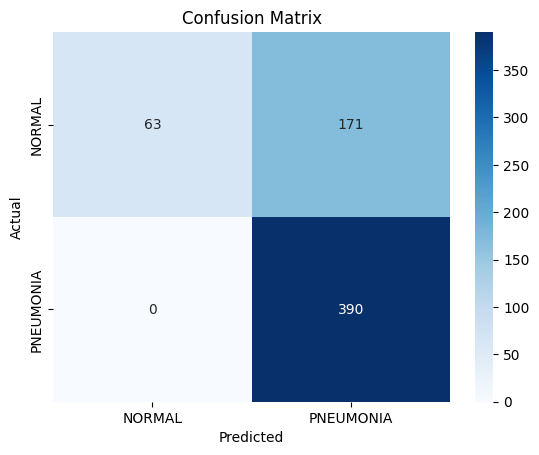


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.27      0.42       234
           1       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.63      0.62       624
weighted avg       0.81      0.73      0.67       624



In [8]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


In [9]:
# Save model
torch.save(model.state_dict(), "pneumonia_model.pth")
print("Model saved as pneumonia_model.pth")


Model saved as pneumonia_model.pth


In [10]:
# Grad-CAM for multiple examples
target_layers = [model.layer4[-1]]

for i in range(5):  # Display 5 Grad-CAM heatmaps
    image_tensor, label = test_data[i]
    input_tensor = image_tensor.unsqueeze(0).to(device)

    original_img = image_tensor.permute(1, 2, 0).numpy()
    original_img = (original_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    original_img = np.clip(original_img, 0, 1)

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

    # Save the heatmap as a PNG
    plt.imshow(visualization)
    plt.title(f"Grad-CAM for class: {train_data.classes[label]}")
    plt.axis('off')
    filename = f"heatmap_sample_{i+1}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    print(f"Saved {filename}")

    cam.__del__()  # Prevent deletion warning




Saved heatmap_sample_1.png
Saved heatmap_sample_2.png
Saved heatmap_sample_3.png
Saved heatmap_sample_4.png
Saved heatmap_sample_5.png


In [11]:
from google.colab import files
files.download("pneumonia_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TypeError: 'module' object is not callable